# DATA-IQ TUTORIAL: SKLEARN STYLE API

In [1]:
import sys
sys.path.insert(0, "../")

# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Imports

In [2]:
from demo_data import load_adult_data
from data_iq.dataiq_class import DataIQ_SKLearn

## Get demo public dataset: Adult

In [3]:
X_train, X_test, y_train, y_test, X, y = load_adult_data(split_size=0.3)


# FIT XGBOOST & then access Data-IQ each per fit iteration

### INITIALIZE DATA-IQ

In [4]:
dataiq_xgb = DataIQ_SKLearn(X=X_train, y=y_train.to_numpy())


In [5]:
nest = 10
clf = xgb.XGBClassifier(n_estimators=nest)
clf.fit(X_train, y_train)

for i in range(1, nest):
    dataiq_xgb.on_epoch_end(clf=clf, iteration=i)


In [6]:
# # EXAMPLE WITH LIGHGBM

# from lightgbm import LGBMClassifier

# # nest = 10
# # TRAIN LIGHTGBM
# clf = LGBMClassifier(n_estimators=nest)
# clf.fit(X_train, y_train)
# accs['gbm'] = round(accuracy_score(clf.predict(X_test),y_test),2)

# # Compute GBM Data-IQ
# dataiq_gbm = DataIQ_SKLearn(X=X_train, y=y_train)
# for i in range(1,nest):
#   dataiq_gbm.on_epoch_end(clf=clf, iteration=i)


In [7]:
# EXAMPLE WITH CATBOOST

# from catboost import CatBoostClassifier


# TRAIN CATBOOST
# clf = CatBoostClassifier(n_estimators=nest)
# clf.fit(X_train, y_train)
# accs['cat'] = round(accuracy_score(clf.predict(X_test),y_test),2)

# Compute Catbosot Data-IQ: Note the catboost=True
# dataiq_catboost = DataIQ_SKLearn(X=X_train, y=y_train, catboost=True)
# for i in range(1,nest):
#   dataiq_catboost.on_epoch_end(clf=clf, iteration=i)


# ACCESS METRICS

#### Aleatoric uncertainty via: `dataiq.aleatoric`
#### Variability via: `dataiq.variability`
#### Predictive confidence via: `dataiq.confidence`
#### Entropy via: `dataiq.entropy`
#### Mutual information via: `dataiq.mi`
#### Correctness over training via: `dataiq.correctness`

In [8]:
aleatoric_uncertainty = dataiq_xgb.aleatoric
confidence = dataiq_xgb.confidence


# PLOT DATA-IQ Characteristic curve:
### X-AXIS: ALEATORIC UNCERTAINTY
### Y-AXIS: PREDICTIVE CONFIDENCE

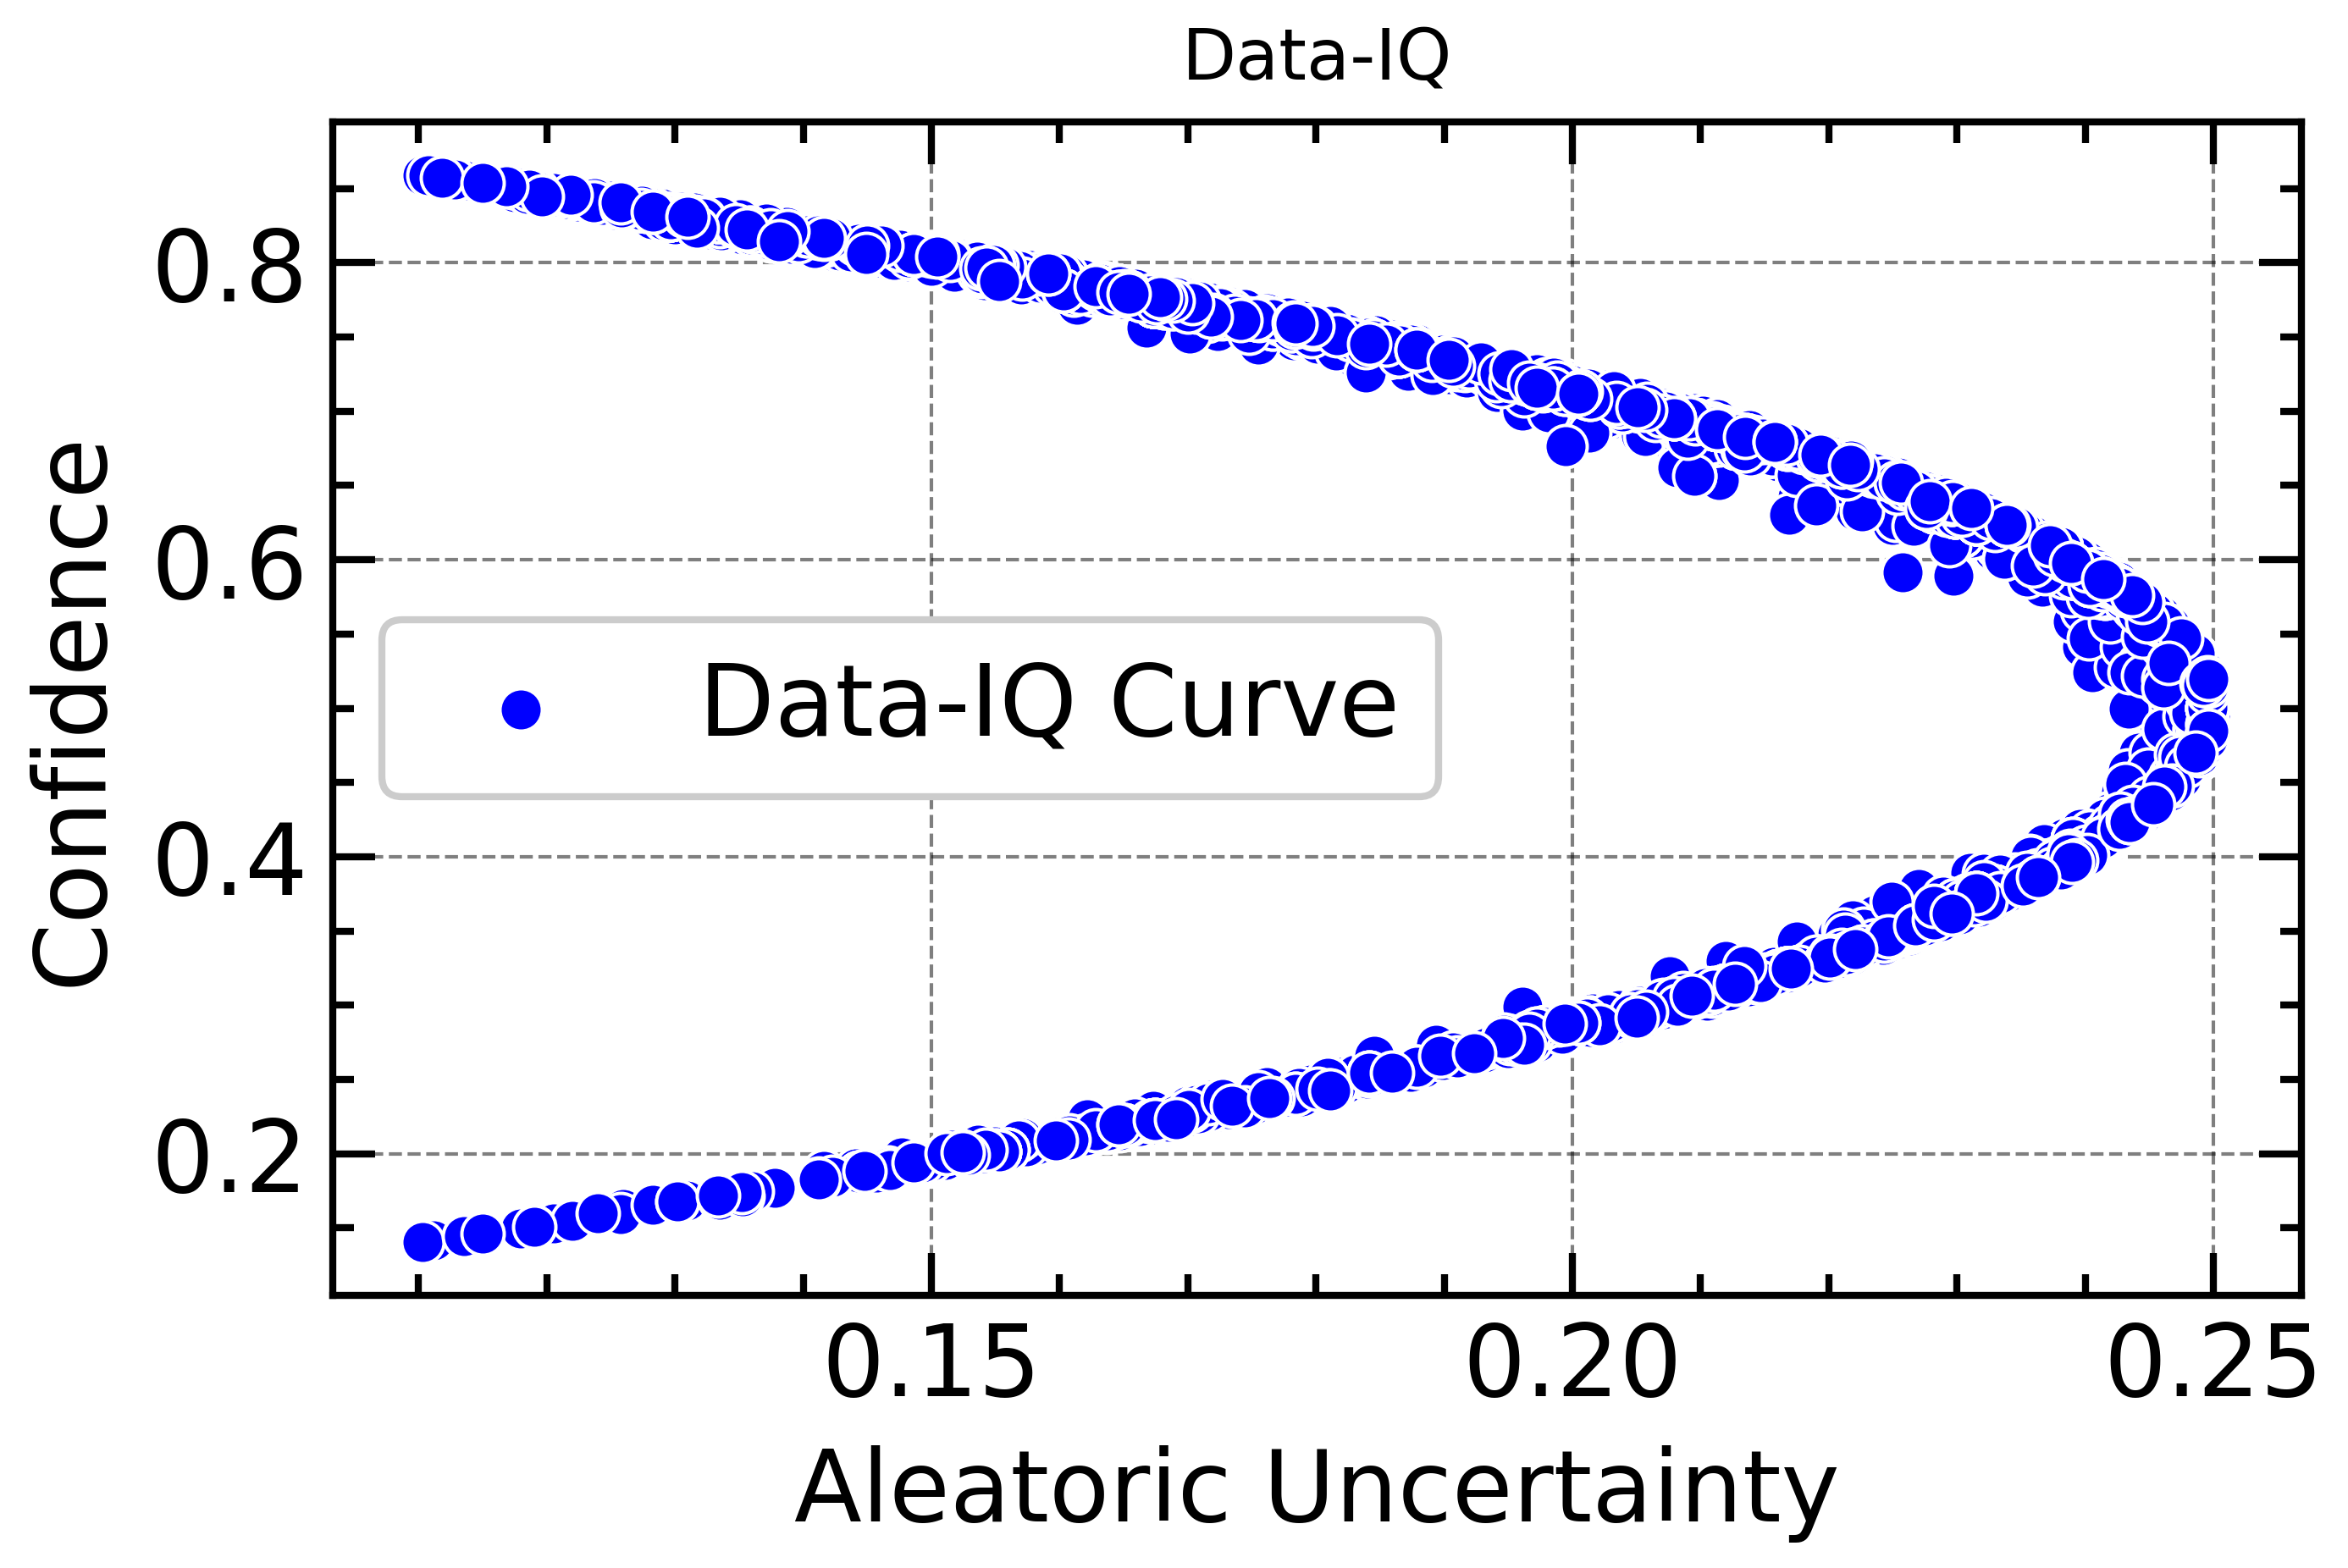

In [9]:
plt.style.reload_library()
plt.style.use(["science", "ieee", "no-latex", "notebook", "grid", "vibrant"])
SMALL_SIZE = 10
MEDIUM_SIZE = 50
BIGGER_SIZE = 50

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=14)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels
plt.rc("legend", fontsize=14)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

# DATA-IQ
plt.figure(figsize=(5, 3))


sns.scatterplot(x=aleatoric_uncertainty, y=confidence, color="b", label="Data-IQ Curve")

plt.title("Data-IQ")
plt.xlabel("Aleatoric Uncertainty")
plt.ylabel("Confidence")
plt.show()


# HOW TO STRATIFY SAMPLES

### DEFINE THRESHOLDS: THESE CAN BE ADAPTED PER USE-CASE

In [10]:
percentile_thresh = 50
thresh = 0.25
conf_thresh_low = thresh
conf_thresh_high = 1 - thresh
conf_thresh = 0.5

hard_train = np.where(
    (confidence <= conf_thresh_low)
    & (aleatoric_uncertainty <= np.percentile(aleatoric_uncertainty, percentile_thresh))
)[0]
easy_train = np.where(
    (confidence >= conf_thresh_high)
    & (aleatoric_uncertainty <= np.percentile(aleatoric_uncertainty, percentile_thresh))
)[0]

hard_easy = np.concatenate((hard_train, easy_train))
ambig_train = []
for id in range(len(confidence)):
    if id not in hard_easy:
        ambig_train.append(id)

ambig_train = np.array(ambig_train)


In [11]:
len(easy_train), len(ambig_train), len(hard_train)

(6211, 7813, 242)